# Fraud detection

## Description

The following case study presents an `Explaratory Data Analysis (EDA)` as well as a `Predictive Analysis` with the aim of forecasting of a binary target.

The `EDA` includes locating and restoring missing data, exploiting inter-correlations of the features in the data set, feature rescaling and feature engineering via the `One-hot-encoding` technique. 

For the `Cross-Validation (CV)` the `kFold` technique with **4 folds** was used. **4 different classifiers** were benchmarked using the train data set. The `CV` has shown uniform performance of all the classifiers accross all the folds. Following the highest AUC-ROC value (**~0.95-0.97**), the `RandomForestClassifier` was chosen as a final model. The model was trained on the full train data set and validated on the test data set. The performance during the validation was lower than in the training however still quite satisfactory, with the AUC-ROC value as high as **~0.65**.

## Outlook

The present analysis may be gradually improved by studying the significance of the available features in detail and more careful feature sellection, using other machine-learning models as well as tuning and optimizing the models.


# Outline
1. [Exploratory data analysis](#Section_1)
  * [Missing values](#Missing_values)
  * [Feature_rescaling](#Feature_rescaling)
  * [One-hot-encoding](#One_hot_encoding)

2. [Predictive analysis](#Section_2)
  * [Model_selection](#Model_selection)
  * [Model training](#Model_training)
  * [Model validation](#Model_validation)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1500)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings                   
warnings.filterwarnings('ignore')

<a id='Section_1'></a>
# Exploratory data analysis

Read the data files.

In [2]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [3]:
df_train.shape

(7003, 31)

Check for duplicates.

In [4]:
df_train.loc[df_train.duplicated()]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,target


In [5]:
df_test.loc[df_test.duplicated()]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,target


<a id='Missing_values'></a>
## Missing values
Check for missing values in data sets.

In [6]:
df_train.isnull().values.any()

True

Since missin values are present, let's locate the corrupted features.

In [7]:
def count_miss_val(df):
    columns = df.columns.to_list()
    
    for column in columns:
        if df[column].isnull().any():
            nNulls = df[column].isnull().sum()
            print(column, nNulls)
            
    return 0

In [8]:
count_miss_val(df_train)

X5 3386
X14 7003
X18 3532


0

The feature `X14` contains only `NaN` values, thus is useless and should be dropped.

In [9]:
df_train.drop(columns = 'X14', axis = 1, inplace = True)
df_test.drop(columns = 'X14', axis = 1, inplace = True)

In [10]:
count_miss_val(df_train[df_train['X18'].isnull()])

X5 1701
X18 3532


0

The corrupted data in `X18` is not always in the same rows as that in `X5`. 

In [11]:
df_train[['X5', 'X18']].describe(include = 'all')

,X5,X18
count,3617,3471.000000
unique,1,NaN
top,False,NaN
freq,3617,NaN
mean,NaN,-1711.086796
std,NaN,981.772625
min,NaN,-4804.662638
25%,NaN,-2406.662726
50%,NaN,-1824.925672
75%,NaN,-1120.251460


In [12]:
df_train['X5'].unique()

array([False, nan], dtype=object)

The feature `X5` contains either `False` or `NaN` values, so it would be impossible to restore any `True` values. Thus the feature is useless in the current state and should be dropped.

In [13]:
df_train.drop(columns = 'X5', axis = 1, inplace = True)
df_test.drop(columns = 'X5', axis = 1, inplace = True)

Let's explore the inter-correlations between the features in order to try to restore missing values in the `X18` feature.

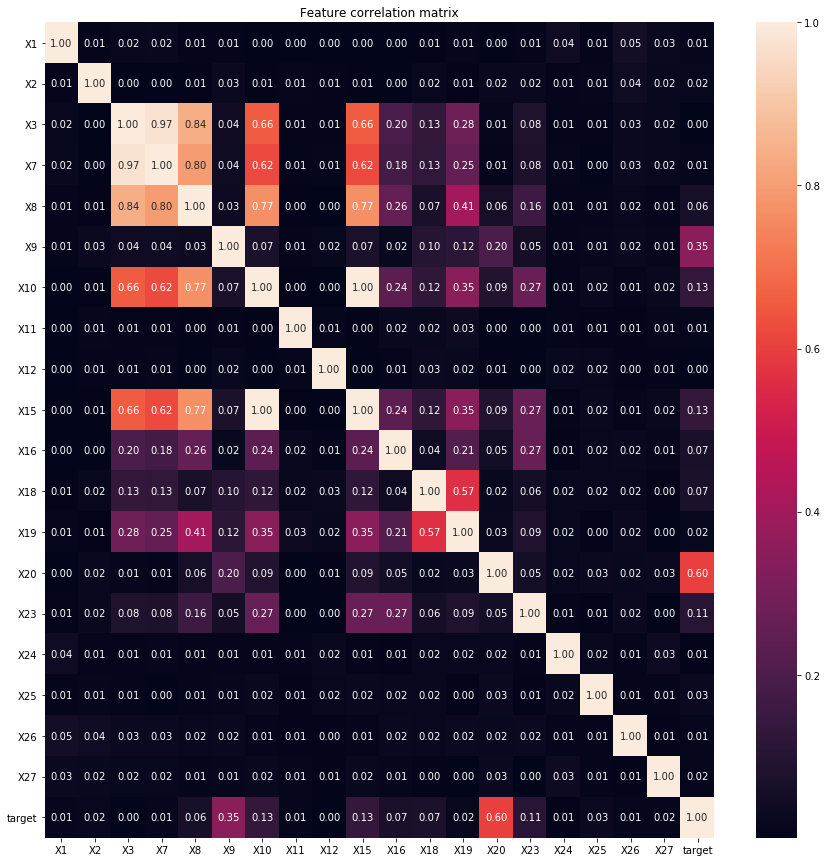

In [14]:
corr = df_train[pd.notnull(df_train['X18'])].corr().abs()
plt.figure(figsize = (15, 15))
sns.heatmap(corr, annot = True, fmt='.2f')

plt.title('Feature correlation matrix')
plt.yticks(rotation=0) 

plt.show()

Some of the features are correlated to `X18` reasinably well. Let's restore the missing data by simple modelling using `LinearRegression`.

In [15]:
corr_cas = corr['X18']
X18_dep_list = corr_cas[corr_cas > 0].sort_values().index.to_list()
X18_dep_list.remove('X18')

In [16]:
X18_X_fill = df_train[pd.notnull(df_train['X18'])][X18_dep_list]
X18_Y_fill = df_train[pd.notnull(df_train['X18'])]['X18']

In [17]:
X18_fill_model = LinearRegression()

In [18]:
res_X18_model = X18_fill_model.fit(X18_X_fill, X18_Y_fill)

In [19]:
res_X18_model.score(X18_X_fill, X18_Y_fill)

0.46505604276659473

In [20]:
def pred_miss_vals(df, corrupted_column, dependancy_list, model):
    for index, row in df.iterrows():
        if pd.isnull(row[corrupted_column]):
            X_for_pred = np.array(row[dependancy_list].to_list()).reshape(1, -1) #single-sample based 
            df[corrupted_column][index] = model.predict(X_for_pred)
            
    return df

In [21]:
df_train = pred_miss_vals(df_train, 'X18', X18_dep_list, res_X18_model)
df_test = pred_miss_vals(df_test, 'X18', X18_dep_list, res_X18_model)

<a id='Feature_rescaling'></a>
## Feature rescaling

Let's explore the peculiarities of the available data. 

In [22]:
df_train.dtypes

X1        float64
X2        float64
X3        float64
X4         object
X6         object
X7        float64
X8        float64
X9        float64
X10       float64
X11       float64
X12       float64
X13        object
X15       float64
X16       float64
X17        object
X18       float64
X19       float64
X20       float64
X21        object
X22        object
X23       float64
X24       float64
X25       float64
X26       float64
X27       float64
X28        object
X29        object
X30        object
target      int64
dtype: object

In [23]:
df_train.head()

,X1,X2,X3,X4,X6,X7,X8,X9,X10,X11,X12,X13,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,target
0,-443.171017,-7.046932,-0.651368,s,l,-2.386104,-12.015035,-53.366720,294.178647,-7.857707e+05,10.358455,e,42.025521,-13.472713,w1,-749.621751,96.728038,0.085353,t4,b,-263.102352,-0.828608,-5915.544513,14.297375,-0.299288,b,z2,x,0
1,-230.778558,-7.046932,-0.552333,s,l,-2.254475,-11.529238,-252.553855,346.713750,-1.578263e+07,10.909010,b,49.530536,116.390270,o1,-2829.294253,294.591527,0.530740,h4,b,-133.804149,-1.111975,-5901.510546,43.164945,0.012027,b,k1,m,0
2,77.218442,-7.046932,-0.291180,s,s,-1.031829,-14.143163,-104.479052,413.070692,-3.170025e+08,10.785486,a,59.010099,1790.830549,b2,-851.316155,250.035442,-0.473562,f1,a,380.620191,-1.015323,-5886.558258,-4.152467,-0.295075,m,s2,r,0
3,-351.346544,-7.046932,-0.525862,s,u,-1.940863,-12.355590,-297.129220,485.092044,-4.827942e+00,10.981424,e,69.298863,1024.139043,k1,-1329.178181,179.150466,0.120289,j3,b,1836.566809,-1.148728,-5902.862408,2.167434,-0.184011,b,s1,l,0
4,-45.761145,-7.046932,-0.484378,s,l,-2.266843,-12.110210,-54.779419,443.408478,-3.567394e+01,10.180999,b,63.344068,6.863769,d1,-2189.781427,286.717140,0.151558,e3,b,-215.838000,-1.147564,-5904.609603,9.709554,0.098385,b,z2,x,0


In [24]:
cont_features = [i for i, value in df_train.dtypes.iteritems() if value == 'float64']
categ_features = [i for i, value in df_train.dtypes.iteritems() if value == 'object']
print('Number of continuous features', len(cont_features))
print('Number of categorical features', len(categ_features))

Number of continuous features 19
Number of categorical features 9


The data consist of **continuous numerical** and **categorical features**. For the ease of modelling the **continuous features should be rescaled** depending on their distributions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25788d50>,
      dtype=object)

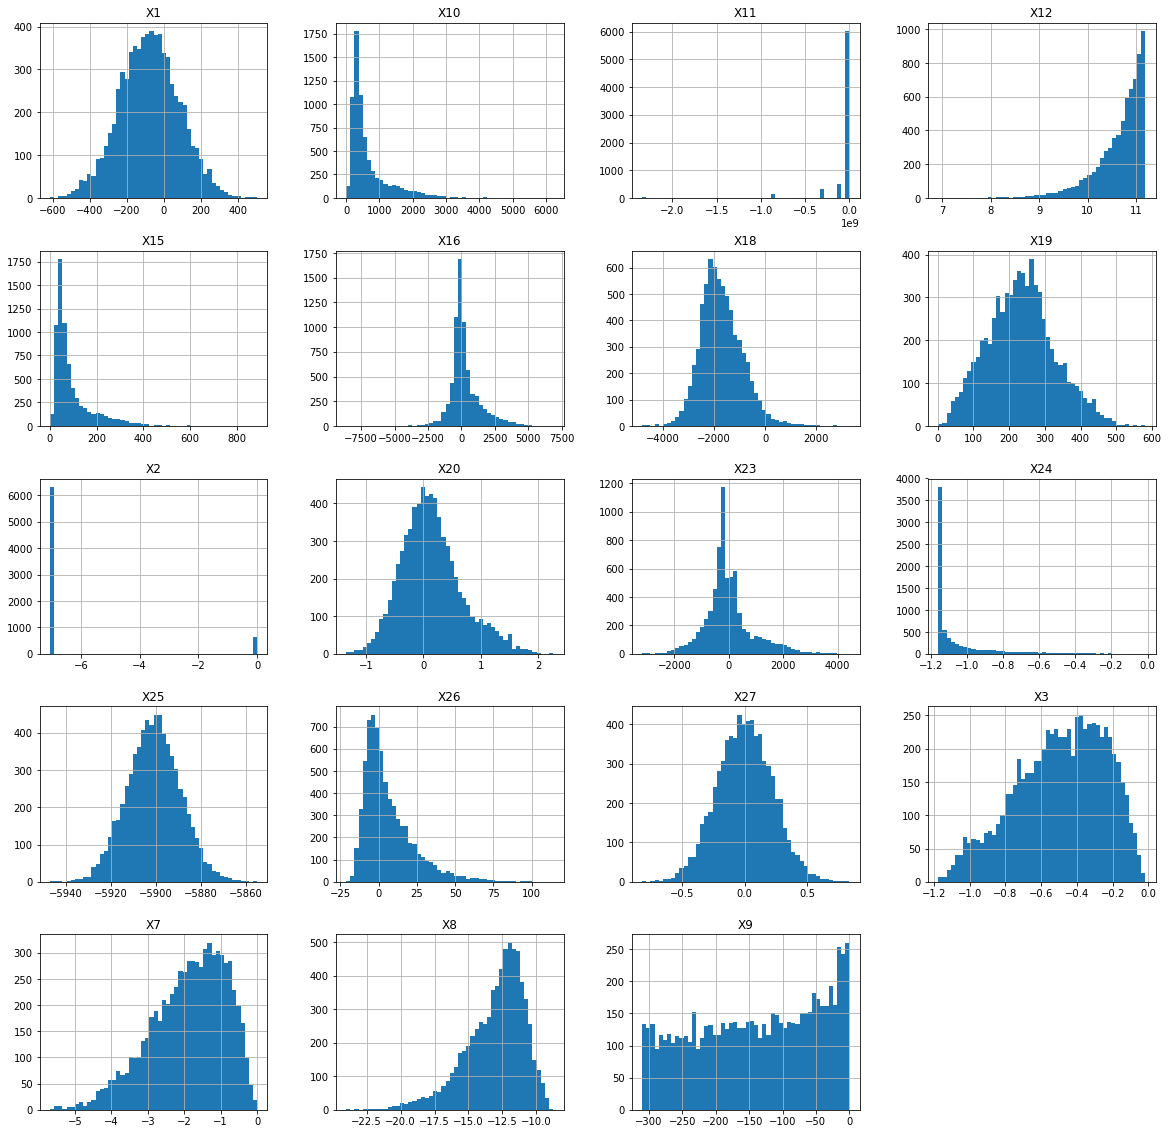

In [25]:
df_train[cont_features].hist(bins=50, figsize = (20, 20))

The features, which are centered around 0 will be rescaled to be in range of **[-1, 1]**, whereas the sparse features will be rescaled to be in range of **[0, 1]**.

In [26]:
cont_zero_cent_feat = ['X1', 'X16', 'X18', 'X20', 'X23', 'X26', 'X27']
cont_sparse_feat = [feature for feature in cont_features if feature not in cont_zero_cent_feat]

In [27]:
def column_scaling(df_train, df_test, feature_list, scaler = 'minmax'):
    if scaler == 'minmax':
        feature_scaler = preprocessing.MinMaxScaler()
    else:
        feature_scaler = preprocessing.MaxAbsScaler()
        
    df_train[feature_list] = feature_scaler.fit_transform(df_train[feature_list])
    df_test[feature_list] = feature_scaler.transform(df_test[feature_list])
        
    return df_train, df_test

In [28]:
df_train, df_test = column_scaling(df_train, df_test, cont_zero_cent_feat, scaler = 'maxabs')

In [29]:
df_train, df_test = column_scaling(df_train, df_test, cont_sparse_feat, scaler = 'minmax')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23a0f410>,
      dtype=object)

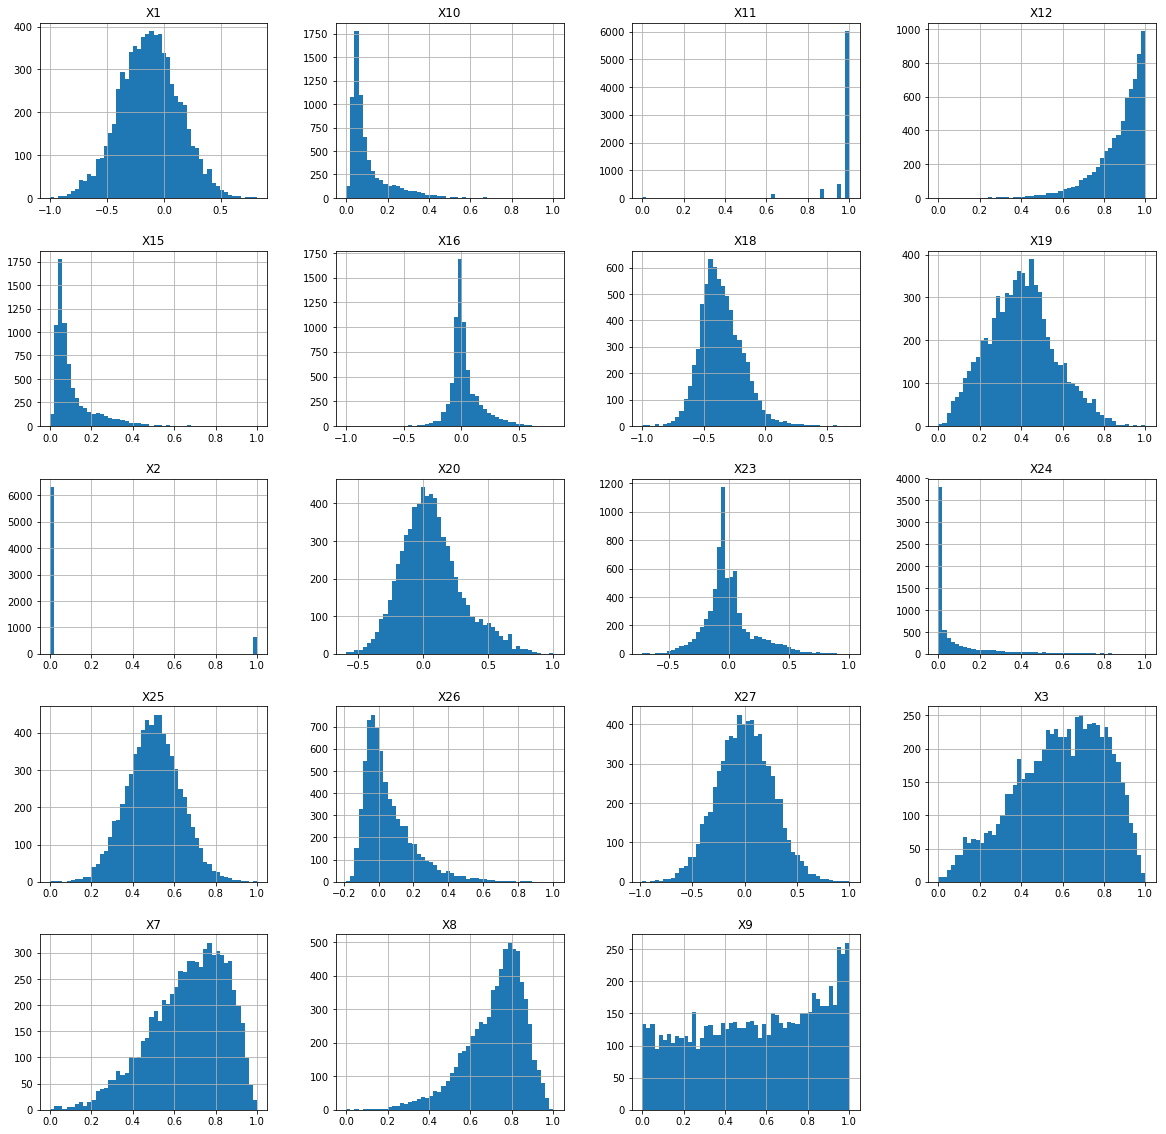

In [30]:
df_train[cont_features].hist(bins=50, figsize = (20, 20))

<a id='One_hot_encoding'></a>
## One-hot-encoding

To the categorical features the so-called **one-hot-encoding** technique will be applied. 

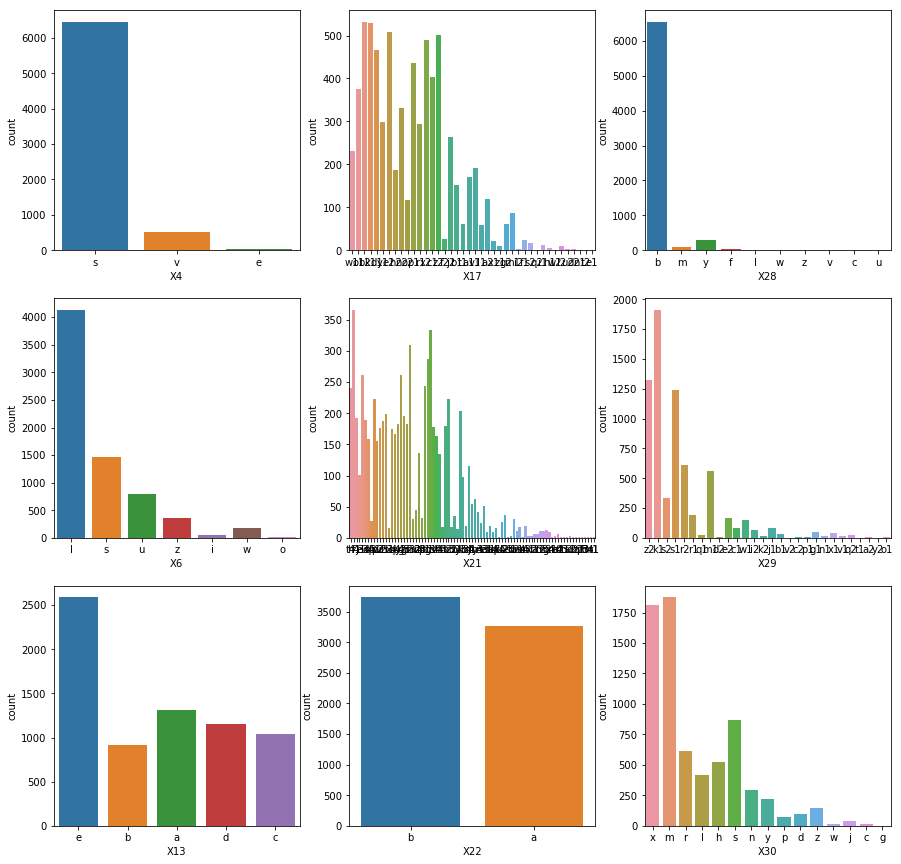

In [31]:
fig, axs = plt.subplots(figsize=(15, 15), ncols = 3, nrows = 3)

for i, feature in enumerate(categ_features):
    sns.countplot(data = df_train, x = feature, ax = axs[i % 3][int(i / 3)])

plt.show()

In [32]:
df_train.shape

(7003, 29)

In [33]:
def one_hot_enc(df, feature_list):
    for feature in feature_list:
        dummies = pd.get_dummies(df[feature], prefix = feature)
        df = pd.concat([df, dummies], axis = 1)
        df.drop([feature], axis = 1, inplace = True)
    return df

In [34]:
df_train = one_hot_enc(df_train, categ_features)
df_test = one_hot_enc(df_test, categ_features)

Let's check if the list of features is the same for train and test samples.

In [35]:
df_train.shape

(7003, 213)

In [36]:
df_test.shape

(1031, 214)

In [37]:
set(df_test.columns).difference(set(df_train.columns))

{'X4_aa'}

In the test data set the feature `X4` contained a category `aa`, which was not there in the train data set. This category will need to be ignored, as we have no means to include it in prediction.

<a id='Section_2'></a>
# Predictive analysis

In [38]:
X_train = df_train.drop(columns = 'target', axis = 1)
Y_train = df_train['target']

<a id='Model_selection'></a>
## Model selection

For the Cross-Validation the `kFold` technique on 4 folds will be used. We will benchmark 4 different classifyers in order to choose an optimal one. 

In [39]:
kfcv = KFold(n_splits = 4)

In [40]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel = 'linear', C = 0.025),
    DecisionTreeClassifier(max_depth = 15, random_state = 42),
    RandomForestClassifier(max_depth = 15, n_estimators = 50, random_state = 42)]

names = ["Nearest Neighbors", "Linear SVM", "Decision Tree", "Random Forest"]

In [41]:
for clf, name in zip(classifiers, names):
    score = cross_validate(clf, X_train, Y_train, cv = kfcv, scoring = 'roc_auc')
    print(name)
    print('ROC-AUC: ' + str(score.get('test_score')))
    print('Fit time' + ': ' + str(score.get('fit_time')) + '\n')

Nearest Neighbors
ROC-AUC: [0.75250573 0.73125689 0.74801127 0.78072368]
Fit time: [0.11778831 0.06686306 0.19572377 0.09317708]

Linear SVM
ROC-AUC: [0.95579685 0.94243327 0.95964578 0.95288902]
Fit time: [2.37601495 1.83022499 1.84831572 1.92665386]

Decision Tree
ROC-AUC: [0.84219482 0.81309287 0.84193821 0.81444937]
Fit time: [0.1654439  0.21315193 0.16490388 0.18951988]

Random Forest
ROC-AUC: [0.96229929 0.96470053 0.9702506  0.95786327]
Fit time: [0.56153798 0.99450397 0.79065394 0.56669283]



As it may be seen, the performance of all the models is quite uniform accross the folds. The performance of the Decision-Tree ensemble is systematically better than that of the rest of the classifyers. The fit time of the Random Forest is also reasonable. Thus the RandomForestClassifier is the model of the choice. 

<a id='Model_training'></a>
## Model training

In [42]:
rf = RandomForestClassifier(max_depth = 15, n_estimators = 50, random_state = 42)

In [43]:
rf_res = rf.fit(X_train, Y_train)

<a id='Model_validation'></a>
## Model validation

In [44]:
X_test = df_test.drop(columns = ['target', 'X4_aa'], axis = 1)
Y_test = df_test['target']

In [45]:
Y_hat = rf_res.predict(X_test)

In [46]:
roc_auc_score(Y_test, Y_hat)

0.6545583884309996

In [47]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_hat)

In [48]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label = 'ROC')
    plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

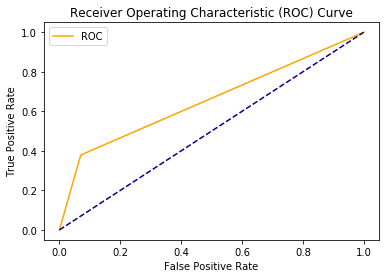

In [49]:
plot_roc_curve(fpr, tpr)

The chosen model performance on the test data is significantly worse with respect to the cases during the cross-validation step. However, the classification is reasonably well, and the ROC curve demonstrates satisfactory behavior. 